In [1]:
library(magrittr)
library(tidyverse)

theme_set(theme_classic(base_family = "Helvetica", base_size = 10) +
theme(          
strip.background = element_blank(),
strip.text.x = element_text(size = 10),
axis.line = element_line(size = .25),
axis.ticks = element_line(size = .25),
axis.text.x = element_text(size = 10),
axis.text.y = element_text(size = 10),
legend.text = element_text(size = 10)
))

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()


In [2]:
rawdata <- read_csv('../data/qrt_pcr/supp_data_3a.csv')
annotations <- read_csv('../data/qrt_pcr/supp_ann_3a.csv')

Parsed with column specification:
cols(
  well = col_character(),
  Ct = col_double()
)
Parsed with column specification:
cols(
  well = col_character(),
  strain = col_character(),
  genotype = col_character(),
  plasmid = col_character(),
  RT = col_character(),
  ng_ul = col_double(),
  primers = col_character(),
  replicate = col_integer()
)


In [3]:
data <- rawdata %>%  
  left_join(annotations, by = 'well') %>% 
  select(-c(strain, well)) %>% 
  group_by(genotype, plasmid, RT, ng_ul, primers) %>% 
  summarize(mean_ct=mean(Ct), sem_ct=(sd(Ct) / sqrt(n()))) %>% 
  ungroup()

# sample data only (ignore gDNA standards)
sample_data <- subset(data, genotype != 'NA')

# unique sample identifier
sample_data$sample <- paste(sample_data$genotype, sample_data$plasmid, sample_data$RT, sep='_')

In [4]:
plot_data <- sample_data %>%
  select(-c(genotype, RT, ng_ul, plasmid)) %>%
  mutate(sample = factor(sample, levels=c('WT_none_+', 'sdaB_none_+',
                                          'sdaC_none_+', 'sdaCB_none_+',
                                          'sdaC_pZS11-sdaC_+', 'sdaCB_pZS11-sdaB_+',
                                          'sdaCB_pZS11-sdaB-native_+',
                                          'WT_none_-'), labels=c('WT',
                                                                  'del_sdaB','del_sdaC','del_sdaCB','pZS-sdaC',
                                                                  'pZS-sdaB','pZS-sdaB-nat','WT-'))) %>%
  mutate(primers = factor(primers, levels=c('sdaB','sdaC','gapA')))

Warning message:
“Removed 7 rows containing missing values (geom_point).”Warning message:
“Removed 7 rows containing missing values (geom_errorbar).”

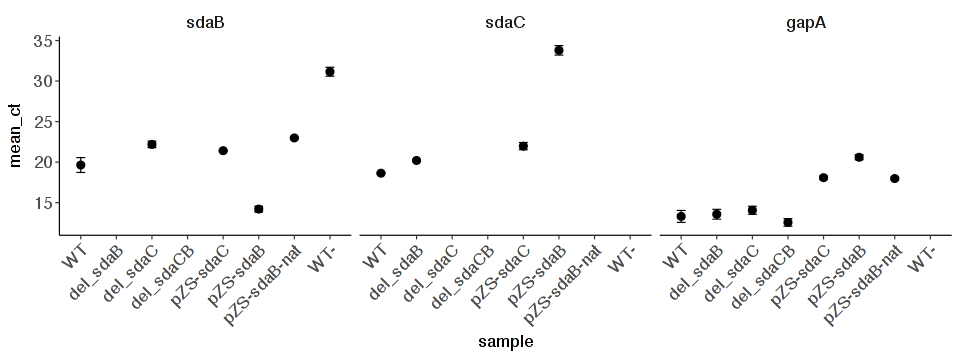

In [5]:
# plot raw Ct values, average and sem of technical duplicates
plot.width = 8
plot.height = 3
options(repr.plot.width=plot.width, repr.plot.height=plot.height)

ggplot(plot_data, aes(x=sample, y=mean_ct)) +
geom_point() + facet_grid(~primers) + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
geom_errorbar(aes(ymin = mean_ct - sem_ct, ymax = mean_ct + sem_ct),
                color = "black", size = 0.25, width = 0.25)

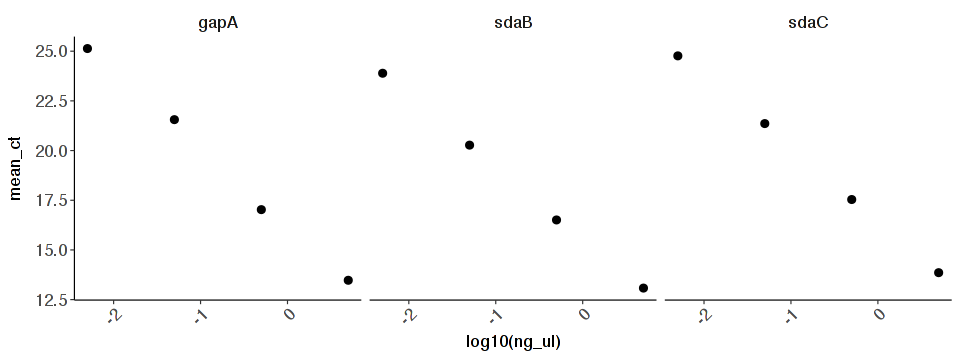

In [6]:
# plot standard curves
# data for gDNA standards only
std_data <- subset(data, ng_ul != 'NA')

ggplot(std_data, aes(x=log10(ng_ul), y=mean_ct)) +
geom_point() + facet_wrap(~primers) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [7]:
# use standard curves to calculate an equation relating quantity (ng/ul) to Ct for each primer set
eqn_gapA <- lm(mean_ct ~ log10(ng_ul), data = subset(std_data, primers == 'gapA'))
eqn_sdaB <- lm(mean_ct ~ log10(ng_ul), data = subset(std_data, primers == 'sdaB'))
eqn_sdaC <- lm(mean_ct ~ log10(ng_ul), data = subset(std_data, primers == 'sdaC'))

In [8]:
gapA <- list(paste('Fitted model: y =', round(coef(eqn_gapA)[1], 3), ' + ',
                               round(coef(eqn_gapA)[2], 3), ' x', sep = ''),
              paste('R^2 == ', round(summary(eqn_gapA)[['r.squared']], 3),
sep = '')  )

gapA

[[1]]
[1] "Fitted model: y =16.132 + -3.951 x"

[[2]]
[1] "R^2 == 0.998"

In [9]:
sdaB <- list(paste('Fitted model: y =', round(coef(eqn_sdaB)[1], 3), ' + ',
                               round(coef(eqn_sdaB)[2], 3), ' x', sep = ''),
              paste('R^2 == ', round(summary(eqn_sdaB)[['r.squared']], 3),
sep = '')  )

sdaB

[[1]]
[1] "Fitted model: y =15.538 + -3.62 x"

[[2]]
[1] "R^2 == 1"

In [10]:
sdaC <- list(paste('Fitted model: y =', round(coef(eqn_sdaC)[1], 3), ' + ',
                               round(coef(eqn_sdaC)[2], 3), ' x', sep = ''),
              paste('R^2 == ', round(summary(eqn_sdaC)[['r.squared']], 3),
sep = '')  )

sdaC

[[1]]
[1] "Fitted model: y =16.451 + -3.656 x"

[[2]]
[1] "R^2 == 0.999"

In [11]:
# for each primer set in each sample, convert Ct value to quantity
gapA_data <- subset(plot_data, primers == 'gapA')
gapA_data$quantity <- 10^((gapA_data$mean_ct - 16.132)/-3.951)

sdaB_data <- subset(plot_data, primers == 'sdaB')
sdaB_data$quantity <- 10^((sdaB_data$mean_ct - 15.538)/-3.62)

sdaC_data <- subset(plot_data, primers == 'sdaC')
sdaC_data$quantity <- 10^((sdaC_data$mean_ct - 16.451)/-3.656)

In [12]:
# normalize sdaB and sdaC to gapA
sdaB_data$quantity_norm = sdaB_data$quantity / gapA_data$quantity
sdaC_data$quantity_norm = sdaC_data$quantity / gapA_data$quantity

### Plotting replicates separately

In [13]:
# generate data table
data <- rawdata %>%  
  left_join(annotations, by = 'well') %>% 
  select(-c(strain, well))

# sample data only (ignore gDNA standards)
sample_data <- subset(data, genotype != 'NA')

# unique sample identifier
sample_data$sample <- paste(sample_data$genotype, sample_data$plasmid, sample_data$RT, sep='_')

# clean up data
plot_data <- sample_data %>%
  select(-c(genotype, RT, ng_ul, plasmid)) %>%
  mutate(sample = factor(sample, levels=c('WT_none_+', 'sdaB_none_+',
                                          'sdaC_none_+', 'sdaCB_none_+',
                                          'sdaC_pZS11-sdaC_+', 'sdaCB_pZS11-sdaB_+',
                                          'sdaCB_pZS11-sdaB-native_+',
                                          'WT_none_-'), labels=c('WT',
                                                                  'del_sdaB','del_sdaC','del_sdaCB','pZS-sdaC',
                                                                  'pZS-sdaB','pZS-sdaB-nat','WT-'))) %>%
  mutate(primers = factor(primers, levels=c('sdaB','sdaC','gapA')))

In [14]:
# for each primer set in each sample, convert Ct value to quantity
gapA_data <- subset(plot_data, primers == 'gapA')
gapA_data$quantity <- 10^((gapA_data$Ct - 16.132)/-3.951)

sdaB_data <- subset(plot_data, primers == 'sdaB')
sdaB_data$quantity <- 10^((sdaB_data$Ct - 15.538)/-3.62)

sdaC_data <- subset(plot_data, primers == 'sdaC')
sdaC_data$quantity <- 10^((sdaC_data$Ct - 16.451)/-3.656)

In [15]:
# average gapA replicates
gapA_data <- gapA_data %>%
  group_by(sample) %>% 
  summarize(mean_quant=mean(quantity)) %>% 
  ungroup()

In [16]:
# normalize each replicate by mean of gapA replicates
sdaB_norm_data <- sdaB_data %>%  
  left_join(gapA_data, by = 'sample') %>%
  select(-c(Ct)) %>%
  mutate(replicate=factor(replicate)) %>%
  rename(gapA_mean = mean_quant) %>%
  mutate(quantity_norm = quantity/gapA_mean)

sdaC_norm_data <- sdaC_data %>%  
  left_join(gapA_data, by = 'sample') %>%
  select(-c(Ct)) %>%
  mutate(replicate=factor(replicate)) %>%
  rename(gapA_mean = mean_quant) %>%
  mutate(quantity_norm = quantity/gapA_mean)

In [49]:
# sdaB plot
plot.width = 4.5
plot.height = 3
options(repr.plot.width=plot.width, repr.plot.height=plot.height)

qrt_plot <- ggplot(sdaB_norm_data, aes(x=quantity_norm*100, y=sample, shape=replicate)) +
geom_point(size=2, position=position_jitter(w=0,h=0.3), col="#000000") + 
scale_x_log10(breaks=c(0.1,1,10,100,1000,10000), limits=c(0.1,10000)) + 
scale_y_discrete(limits = rev(levels(plot_data$sample))) + annotation_logticks(sides = 'b') +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
xlab('sdaB mRNA levels w.r.t. gapA')

ggsave('../pdf/supp_3a_sdab.pdf', width = plot.width, height = plot.height, units = 'in', device=cairo_pdf)

Warning message:
“Removed 6 rows containing missing values (geom_point).”

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message:
“Removed 8 rows containing missing values (geom_point).”

Warning message:
“Removed 8 rows containing missing values (geom_point).”

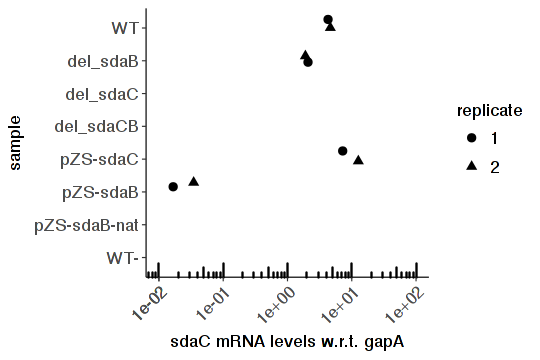

In [52]:
# sdaC plot
qrt_plot %+% sdaC_norm_data %+% scale_x_log10(breaks=c(0.01,0.01,0.1,1,10,100), limits=c(0.01,100)) %+% xlab('sdaC mRNA levels w.r.t. gapA')

ggsave('../pdf/supp_3a_sdac.pdf', width = plot.width, height = plot.height, units = 'in', device=cairo_pdf)